# Basketball (or Netball) Cannon Toy Problem

Develop a controller for a basketball cannon.  Given the following inputs
1. distance from the basket
2. height from which the ball leaves the cannon
3. speed the ball will leave the cannon

**What angle should the cannon aim the ball such that it will go through the basket without interacting with the backboard or the rim.**

Note that this scenario is actually more similar to Netball than Basketball, since we are neglecting the backboard.
<img src="https://netballamerica.com/wp-content/uploads/1DX28219.jpg">

In [296]:
# import some basic packages
import itertools
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import Tuple

In [2]:
np.set_printoptions(suppress=True)

In [307]:
import seaborn as sns

In [3]:
from bokeh import plotting
from bokeh.palettes import Dark2_8 as palette
colors = itertools.cycle(palette)

In [4]:
plotting.output_notebook()

Loading BokehJS ...

In this problem, we observe that the parameters are such that the cannon is always aimed in the vertical plane connecting the cannon and the hoop. We can separate the motion of the ball into the horizontal, $x$, and vertical, $y$, directions.  The position in both directions can be written using the linear equations of motions as follows.

$$x(t) = x_0 + \dot{x}_0 t + \frac{1}{2} \ddot{x}_0 t^2$$

$$y(t) = y_0 + \dot{y}_0 t + \frac{1}{2} \ddot{y}_0 t^2$$

We can set the x and y origin at the base of the cannon, so the ball leaves the cannon at $(x_0, y_0) = (0, h_0)$.  The speed at which the ball leaves the cannon is written in terms of x and y as $(\dot{x}_0, \dot{y}_0) = (v\cos\theta, v\sin\theta)$.  The only acceleration in this situation is gravity so $(\ddot{x}_0, \ddot{y}_0) = (0, g)$.  Based on these values, the equations of motion can be written as

$$x(t) = v\cos(\theta) t$$

$$y(t) = h_0 + v\sin(\theta) t + \frac{1}{2}g t^2$$


To measure how close each shot gets to the basket, we want to consider the time when the ball passes the height of the basket, $h_{b}$, for the second time.  

$$\frac{1}{2} g t^2 + v \sin(\theta) t + \delta_h = 0$$

where $\delta_h$ is the difference in height, $\delta_h = h_0 - h_{basket}$.  This occurs when 

$$t = \frac{-v \sin(\theta) \pm \sqrt{v^2 \sin^2(\theta)+2gh}}{g}$$

Note that in order to have a reasonable throw, using the assumption that the cannon is always below the rim, the trajectory of the ball must form an arch passing the height of the rim twice.  This only occurs when the descriminant is positive, which means

$$v^2 > \frac{-2 g h}{sin^2(\theta)}$$

Lets begin by defining a cannon class that expects the three inputs: distance, height, and speed.  We also define the `fire(angle)` method which fires the cannon at the specified angle, recording the ball's trajectory and the  position the ball intersects the horizontal plane of the hoop.  We also define a `show_path` method which plots all `fire` attempts.

Note that we are using a ball width of 24 cm, and a rim that is twice that width.  This means that the ball goes through the rim if the center of the ball is within half the ball width of the center of the rim.

In [166]:
class Cannon():
    def __init__(self, dist: float, height: float, speed: float) -> None: 
        # constants
        self.ball_radius = 9.5 / 12 / 2 # ft
        self.height_basket = 10  # ft
        self.g = -32.174  # ft/s^2

        # cannon parameters
        self.dist = dist  # ft, distance to hoop
        self.height = height  # ft, height of the cannon
        self.speed = speed  # ft/s
        
        self.delta_h = self.height_basket - self.height
        self.rim = dist + self.ball_radius * np.array([-1, 1])  # m

        self.path = []
        self.angle = 0
        
    def fire(self, angle: float):         
        self.angle = np.deg2rad(angle)
        if angle < 0 or 90 < angle:
            # TODO: consider this case further
            self.delta_x = np.nan
            return self.delta_x
        
        cos = np.cos(self.angle)
        sin = np.sin(self.angle)

        self.result = 'terrible shot'
        D = (self.speed * sin) ** 2 + 2 * self.g * self.delta_h
        if D > 0:  # ball passes through correct height twice
            self.t_m = (-self.speed * sin - np.sqrt(D)) / self.g  # negative root is the downward part of the arc
            self.x_shot = self.speed * cos * self.t_m  
            self.delta_x = self.x_shot - self.dist  # neg: undershot, pos: overshot
            if self.rim[0] < self.x_shot < self.rim[1]:
                self.result = 'success'
            else:
                self.result = 'miss'
            t_final = self.t_m * 1.1
        else:
            # TODO: consider this case further
            self.delta_x = np.nan  # what's a better way to treat this?
            t_final = 1.5  # s

        t = np.linspace(0, t_final, 100)  # 0 to 10 s
        x = self.speed * cos * t
        y = self.height + self.speed * sin * t + self.g * t**2 / 2
        self.path.append(np.c_[x, y][y >= 0])
        
        return self.delta_x
    
#     # double check this calculation
#     def _dx(self, angle):
#         sin = np.sin(angle)
#         cos = np.cos(angle)
#         D = (self.speed * sin) ** 2 + 2 * self.g * self.delta_h
#         sqrt_D = np.sqrt(D)
#         dx = (self.speed ** 2 / self.g * (sin ** 2 - cos ** 2) 
#               - self.speed * sin / self.g * (-sqrt_D + (self.speed * cos) ** 2 / sqrt_D))
#         return dx        
        
    def show_path(self):
        if self.path:
            p = plotting.figure(
                width=800, height=400, 
                x_axis_label='(ft)', y_axis_label='(ft)',
                x_range=(-1, self.dist*1.3), y_range=(-0.5, 20),
            )

            # plot the hoop
            p.line(np.array([1, 1.015, 1.015]) * self.rim[1], 
                   [self.height_basket, self.height_basket, 0], color='gray')
            p.circle(self.rim, self.height_basket,  
                     radius=0.02, color='orange')
            p.line(self.rim, self.height_basket, color='orange')

            # plot the attempts
            for i, (path, color) in enumerate(zip(self.path, colors)):
                name = f'Attempt {i+1}'
                p.line(path[:, 0], path[:, 1], color=color, 
                       legend_label=name, muted_alpha=0.2)
                t = np.linspace(0, 1, 100)
                
            # plot the last cannon
            p.line(0, [0, self.height], color='black')
            p.line(
                [-np.cos(self.angle)/2, 0], 
                [self.height - np.sin(self.angle)/2, self.height],
                line_width=5, color=color,
            )

            p.legend.location = 'top_right'
            p.legend.click_policy = 'mute'
            p.toolbar.autohide = True
            plotting.show(p)
        else:
            print('Error: no attempts made!')

Lets look at a cannon placed roughly at the free-throw line, 5 meters from the basket, shot from 2 meters above the ground, and fired at 8 meters per second.

In [20]:
freethrow = Cannon(13, 7, 23.7)

for angle in [45, 40, 43, 60]:
    delta_x = freethrow.fire(angle)
    print(f'{angle} degrees: {freethrow.result} ({delta_x:0.2f} ft away)')

freethrow.show_path()

45 degrees: miss (0.61 ft away)
40 degrees: miss (-0.88 ft away)
43 degrees: success (0.16 ft away)
60 degrees: success (0.12 ft away)


We see that the first shot, at an angle of 45 degrees, was 0.61 feet past the basket.
The second shot, at an angle of 40 degrees, was 0.88 feet short of the basket.
The third shot, at 43 degrees went through the basket.
Maybe surprising, the fourth shot, at 60 degrees, also went through the basket.

Lets position the cannon roughtly at the three-point line, 7 meters from the basket.  We will use the same height, but increase the velocity a bit as we are a bit farther away.

In [34]:
three_point = Cannon(23, 7, 29.3)

d45 = three_point.fire(45)  # Rachael's first attempt
print(f'{np.rad2deg(three_point.angle)} degrees: {three_point.result} ({three_point.delta_x:0.2f} ft away)')
d54 = three_point.fire(54)  # 2nd angle
print(f'{np.rad2deg(three_point.angle)} degrees: {three_point.result} ({three_point.delta_x:0.2f} ft away)')
three_point.show_path()

45.0 degrees: success (0.24 ft away)
54.0 degrees: success (-0.03 ft away)


How do we figure out the angle for other situations?  We could always brute force a solution.

In [41]:
c3 = Cannon(15, 2, 35)
res = []
for angle in range(45, 85):
    res.append(c3.fire(angle))

c3.show_path()

## Learn what angle to fire the cannon

A more interesting approach is to create an agent that can explore firing this cannon to experimentally learn what angle to aim the cannon to successfully fire the ball into the hoop.

The goal for our agent, or cost function we want to minimize, is the distance the ball passes from the center of the basket (`delta_x`).

In [42]:
class Agent():
    def __init__(self, cannon, learning_rate, decay_rate):
        self.cannon = cannon
        self.lr = learning_rate
        self.rng = np.random.default_rng()
        self.decay_rate = decay_rate
    
    def _step(self, i):
        # this is not the best as it is only one-sided
        d_delta_x = np.abs(self.results[i, 1]) - np.abs(self.results[i-1, 1])
        d_angle = self.results[i, 0] - self.results[i-1, 0]
        self.lr /= 1 + self.decay_rate
        step = self.lr * d_delta_x / d_angle
        self.results[i+1, 0] = self.results[i, 0] - step        
    
    def learn(self, max_iters, *, angle_0=89):
        # hacky gradient descent
        
        self.results = np.empty((max_iters, 2))
        
        delta_x_0 = self.cannon.fire(angle_0)
        self.results[0, :] = angle_0, delta_x_0
        
        angle_1 = angle_0 + self.rng.choice([-1, +1])
        delta_x_1 = self.cannon.fire(angle_1)
        self.results[1, :] = angle_1, delta_x_1
        self._step(1)

        
        for i in range(2, max_iters-1):
            self.results[i, 1] = self.cannon.fire(self.results[i, 0])
            if np.abs(self.results[i, 1]) < self.cannon.ball_radius:
                print(f'use {self.results[i, 0]:.1f} degrees to get it in the basket')
                break
            elif np.isnan(self.results[i, 1]):
                print(f'failed to converge on solution using {self.results[0, 0]} as initial angle')
                break
            self._step(i)
        
        self.results = self.results[:i+1]

Test the agent with a cannon that is 15 feet away, 2 feet off the ground, and firing at a speed of 15 meters / second.

Use an initial guess of 20 degrees.

In [100]:
c3 = Cannon(15, 2, 30)
learning_rate = 0.8
decay_rate = 0.01
johnny5 = Agent(c3, learning_rate, decay_rate)
johnny5.learn(100, angle_0=80)


use 69.4 degrees to get it in the basket


In [101]:
johnny5.results

array([[80.        , -7.15244953],
       [79.        , -6.4204568 ],
       [78.42020378, -6.00285562],
       [77.8553532 , -5.60113752],
       [77.30313122, -5.21352177],
       [76.76350603, -4.83986075],
       [76.23643555, -4.47997886],
       [75.72185537, -4.1336667 ],
       [75.21968041, -3.80068517],
       [74.72980675, -3.48076934],
       [74.25211333, -3.17363217],
       [73.78646359, -2.87896798],
       [73.33270707, -2.59645571],
       [72.89068094, -2.32576193],
       [72.46021137, -2.06654364],
       [72.04111497, -1.81845082],
       [71.6332    , -1.58112872],
       [71.2362676 , -1.35421998],
       [70.85011291, -1.1373665 ],
       [70.47452609, -0.93021109],
       [70.10929327, -0.73239902],
       [69.75419749, -0.54357925],
       [69.40901949, -0.36340557]])

In [102]:
c3.show_path()

In [103]:
len(johnny5.results)

23

The agent found the correct angle in 23 or 28 trials, depending on which direction the first step goes, with several oscillations around the correct answer.  This means our initial learning rate is too large, or our decay rate is too small.  Looking at the initial step, they are never more than a degreee, se we could reasonably increase the initial learning rate.  

Lets increase both the learning rate and the decay rate. 

In [118]:
c3 = Cannon(15, 2, 30)
learning_rate = 3
decay_rate = 0.1
johnny5 = Agent(c3, learning_rate, decay_rate)
johnny5.learn(100, angle_0=80)

use 69.4 degrees to get it in the basket


In [119]:
johnny5.results

array([[80.        , -7.15244953],
       [79.        , -6.4204568 ],
       [77.00365618, -5.00551363],
       [75.24638195, -3.81826365],
       [73.72357156, -2.83953535],
       [72.40662902, -2.03458699],
       [71.26806088, -1.37224646],
       [70.28294471, -0.82599838],
       [69.42930437, -0.37390068]])

In [120]:
c3.show_path()

In [121]:
len(johnny5.results)

9

Now it found a valid angle in only 9 or 11 steps, depending on which direction the first step goes, with the initial steps being a little less than 2 degrees.


Lets use the same cannon with a initial angle of 40 degrees.

In [143]:
c3 = Cannon(15, 2, 30)
learning_rate = 3
decay_rate = 0.05
johnny5 = Agent(c3, learning_rate, decay_rate)
johnny5.learn(200, angle_0=60)

use 68.2 degrees to get it in the basket


In [144]:
johnny5.results

array([[60.        ,  3.0138037 ],
       [61.        ,  2.81865191],
       [61.55757654,  2.69037153],
       [62.18361126,  2.53045885],
       [62.84558054,  2.34373589],
       [63.54176439,  2.12852182],
       [64.26840804,  1.88405288],
       [65.02156876,  1.61007955],
       [65.79713123,  1.30689532],
       [66.59090491,  0.97531815],
       [67.39870795,  0.61665353],
       [68.21644057,  0.23264145]])

In [145]:
c3.show_path()

This shows we were able to get to both successful angles starting from the scenario of both under and over shooting.  Further exploration could be given to tuning the learning rate and decay rate to imporove the step size and avoid oscillation around the hoop.  Also, this solution will only work for angle between 0 and 90 degrees.  We did not consider the possibility of the cannon being higher than the basket, in which case angles below 0 degrees are viable options.  There are certainly several alternative approaches that could be taken, one of which would be reinforcement learning, defining a punishment based on how far each shot is from the basket, and a reward for successfully shooting the ball the basket.

## Model the angle to use as a function of possible input combinations

Taking this a bit further, lets develop a model of the cannon across all possible input parameters within a specified design space.  We will use the following ranges for distance and height

- distance: 5-25 ft 
- height: 0-10 ft

For speed, we will determine the minimum speed required to make a shot the furthest shot, 25 ft away with a height of 0 ft.  This will be the minimum speed for our design space.  The maximum speed will be two times that minimum speed.  Rather than calculate this exactly, lets just experiment with our cannon to figure out what to use.

In [223]:
c_max = Cannon(25, 0, 34.3)
r2d2 = Agent(c_max, 2, 0.01)
r2d2.learn(50, angle_0=55)

use 55.7 degrees to get it in the basket


In [224]:
r2d2.results

array([[55.        , -0.43196173],
       [54.        , -0.56262405],
       [54.25873727, -0.51996136],
       [54.58201552, -0.47549742],
       [54.84900694, -0.44591613],
       [55.06195037, -0.42680568],
       [55.23272761, -0.41428252],
       [55.37088866, -0.40594197],
       [55.48350184, -0.40031078],
       [55.57585884, -0.39646547],
       [55.65199652, -0.39381424]])

In [225]:
c_max.show_path()

In [247]:
c_max = Cannon(25, 0, 34.3)
for angle in np.linspace(55.5, 56.5, 11):
    c_max.fire(angle)
    print(f'{angle:0.2f} degrees: {c_max.result} ({c_max.delta_x:0.2f} ft away)')
    
c_max.show_path()

55.50 degrees: miss (-0.40 ft away)
55.60 degrees: success (-0.40 ft away)
55.70 degrees: success (-0.39 ft away)
55.80 degrees: success (-0.39 ft away)
55.90 degrees: success (-0.39 ft away)
56.00 degrees: success (-0.39 ft away)
56.10 degrees: success (-0.39 ft away)
56.20 degrees: success (-0.39 ft away)
56.30 degrees: success (-0.39 ft away)
56.40 degrees: success (-0.39 ft away)
56.50 degrees: success (-0.39 ft away)


So for the farthest the cannon can be, the minimum speed I could get to go in is 34.3 $ft/s^2$, which means our max speed will be 68.6 $ft/s^2$.

Lets consider the edges and center points of the design space, figuring out what angle works for each.

In [352]:
distance_range = [5, 15, 25]
height_range = [0, 5, 10]
speed_range = [34.3, 51.45, 68.6]
points = np.array(np.meshgrid(distance_range, height_range, speed_range)).T.reshape(-1, 3)
points = np.c_[points, np.empty(len(points))]
points

array([[ 5.  ,  0.  , 34.3 ,  0.  ],
       [ 5.  ,  5.  , 34.3 ,  0.  ],
       [ 5.  , 10.  , 34.3 ,  0.  ],
       [15.  ,  0.  , 34.3 ,  0.  ],
       [15.  ,  5.  , 34.3 ,  0.  ],
       [15.  , 10.  , 34.3 ,  0.  ],
       [25.  ,  0.  , 34.3 ,  0.  ],
       [25.  ,  5.  , 34.3 ,  0.  ],
       [25.  , 10.  , 34.3 ,  0.  ],
       [ 5.  ,  0.  , 51.45,  0.  ],
       [ 5.  ,  5.  , 51.45,  0.  ],
       [ 5.  , 10.  , 51.45,  0.  ],
       [15.  ,  0.  , 51.45,  0.  ],
       [15.  ,  5.  , 51.45,  0.  ],
       [15.  , 10.  , 51.45,  0.  ],
       [25.  ,  0.  , 51.45,  0.  ],
       [25.  ,  5.  , 51.45,  0.  ],
       [25.  , 10.  , 51.45,  0.  ],
       [ 5.  ,  0.  , 68.6 ,  0.  ],
       [ 5.  ,  5.  , 68.6 ,  0.  ],
       [ 5.  , 10.  , 68.6 ,  0.  ],
       [15.  ,  0.  , 68.6 ,  0.  ],
       [15.  ,  5.  , 68.6 ,  0.  ],
       [15.  , 10.  , 68.6 ,  0.  ],
       [25.  ,  0.  , 68.6 ,  0.  ],
       [25.  ,  5.  , 68.6 ,  0.  ],
       [25.  , 10.  , 68.6 ,  0.  ]])

In [353]:
results = []
for i in range(len(points)):
    c_i = Cannon(*points[i, :3])
    bot_i = Agent(c_i, 0.1, 0.001)
    bot_i.learn(500, angle_0=89)
    results.append(bot_i.results)
    points[i, 3] = bot_i.results[-1, 0]

use 85.6 degrees to get it in the basket
use 86.0 degrees to get it in the basket
use 86.4 degrees to get it in the basket
use 75.4 degrees to get it in the basket
use 77.1 degrees to get it in the basket
use 78.2 degrees to get it in the basket
use 66.2 degrees to get it in the basket
use 68.8 degrees to get it in the basket
use 88.1 degrees to get it in the basket
use 88.3 degrees to get it in the basket
use 88.1 degrees to get it in the basket
use 84.5 degrees to get it in the basket
use 84.7 degrees to get it in the basket
use 84.9 degrees to get it in the basket
use 80.5 degrees to get it in the basket
use 80.9 degrees to get it in the basket
use 81.1 degrees to get it in the basket
use 89.0 degrees to get it in the basket
use 89.0 degrees to get it in the basket
use 89.0 degrees to get it in the basket
use 87.0 degrees to get it in the basket
use 87.0 degrees to get it in the basket
use 87.1 degrees to get it in the basket
use 85.0 degrees to get it in the basket
use 85.2 degrees

In [354]:
points

array([[ 5.        ,  0.        , 34.3       , 85.59357786],
       [ 5.        ,  5.        , 34.3       , 86.01990601],
       [ 5.        , 10.        , 34.3       , 86.36222661],
       [15.        ,  0.        , 34.3       , 75.43092423],
       [15.        ,  5.        , 34.3       , 77.14423853],
       [15.        , 10.        , 34.3       , 78.17705177],
       [25.        ,  0.        , 34.3       , 60.97906017],
       [25.        ,  5.        , 34.3       , 66.15178156],
       [25.        , 10.        , 34.3       , 68.77986832],
       [ 5.        ,  0.        , 51.45      , 88.12880849],
       [ 5.        ,  5.        , 51.45      , 88.33735424],
       [ 5.        , 10.        , 51.45      , 88.14706267],
       [15.        ,  0.        , 51.45      , 84.45617509],
       [15.        ,  5.        , 51.45      , 84.70925047],
       [15.        , 10.        , 51.45      , 84.88165045],
       [25.        ,  0.        , 51.45      , 80.5103038 ],
       [25.        ,  5.

In [355]:
points_df = pd.DataFrame(points)

points_df.columns=['distance', 'height', 'speed', 'angle']

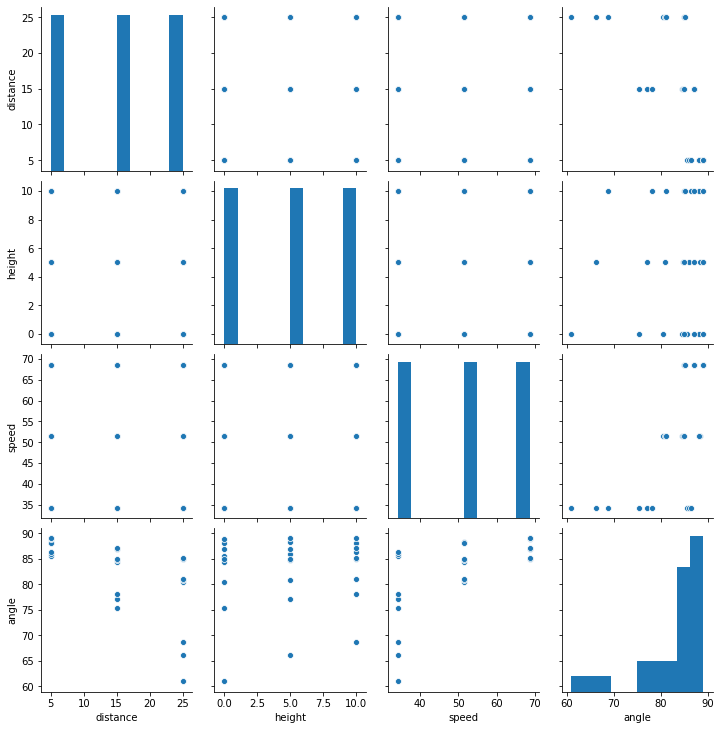

In [356]:
sns.pairplot(points_df)

These plots compare each pair of columns from our data table containing the input parameters and the angles that produced a successful shot.  The bottom row of plots is insightful, looking at the angle response as a function of each of the input parameters.  We can see that distance and speed have second order curvature.

There were many other attempts that did not make it in the basket.  For each of these, the `results` info contained the horizontal distance from the center of the basket.  Lets look at the pair-plot for all the attemps.

In [357]:
attempts_all = []
for i in range(len(points)):
    attempts_i = pd.DataFrame(results[i])
    attempts_i.columns = ['angle', 'delta_x']
    for column in ['distance', 'height', 'speed']:
        attempts_i[column] = points_df.iloc[i][column]
    attempts_all.append(attempts_i)
attempts = pd.concat(attempts_all)

In [358]:
attempts

,angle,delta_x,distance,height,speed
0,89.000000,-3.932520,5.0,0.0,34.3
1,88.000000,-2.866815,5.0,0.0,34.3
2,87.893536,-2.753534,5.0,0.0,34.3
3,87.787345,-2.640585,5.0,0.0,34.3
4,87.681300,-2.527836,5.0,0.0,34.3
...,...,...,...,...,...
105,85.158466,-0.398351,25.0,10.0,68.6
106,85.452545,-1.879694,25.0,10.0,68.6
107,84.999461,0.401523,25.0,10.0,68.6
108,84.706304,1.874176,25.0,10.0,68.6


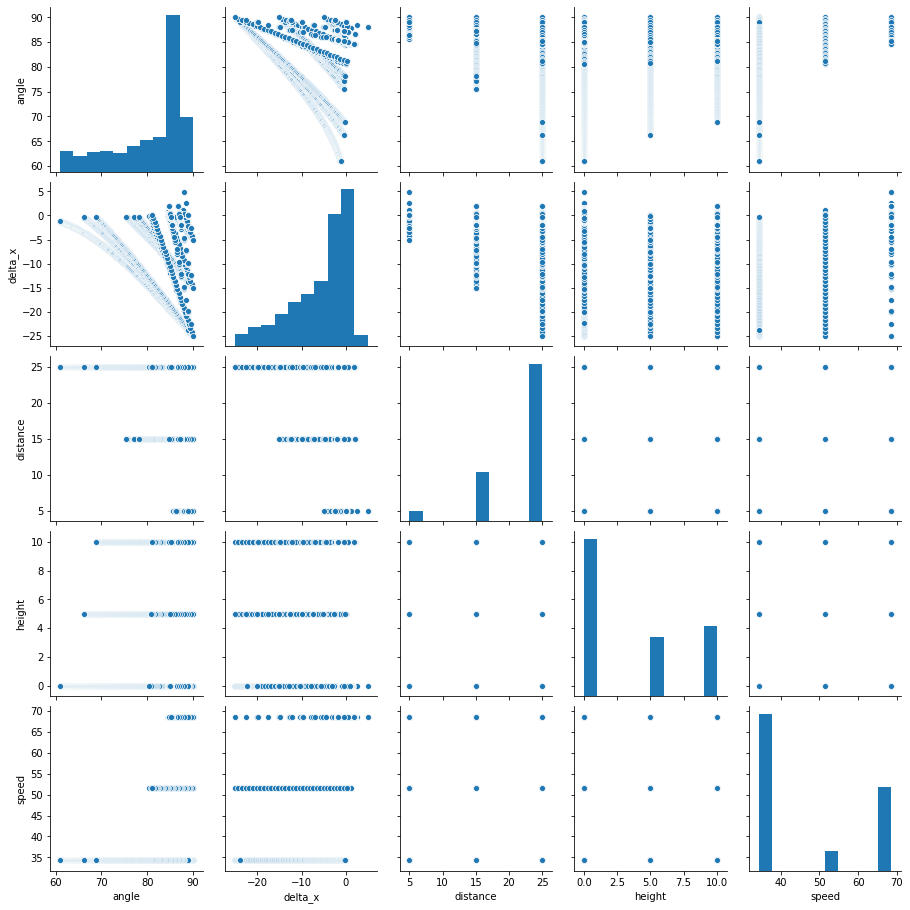

In [359]:
sns.pairplot(attempts)

It is important to note that the points in this plot represent all of the attempts, not just the successful shots.  

We clearly see some interesting behavior in the `delta_x` versus `angle` plot, showing the agent find the correct angle.  Most of these traces appear almost linear, which might be useful in plotting a trend-line to predict the angle that would make the shot.  This seem to be the case primarily because with these speeds the angles are all relatively close to 90 degrees.  The shallowest angle, around 60 degrees, is not linear.  Perhaps a second order function could accurately describe both the steep and shallow angles.  If this does prove reliable, given any set of input parameters, the bot should be able to fire three shots then fit a curve to the result to generate a predictor for that set of inputs.  If this works, the agent would require almost no data to train, just three shots at every point.  The downside is without any other logic, any input would require making three shots to get a valid prediction.  One could in theory implement a look-up table of past input parameters but this is not practicle for a continuously varying design space.

My first thought at generating a generalizable model is to take a design of experiments approach, generating an I-optimal design, which would minimize the prediction variance across the design space.  For each set of points in the design, we would find the correct shot angle, then fit a response model to predict the values across this design space. 

For either of these approaches, we could evaluate the model using a series of randomly sampled input parameters, then rank the models by how many of the shots they make.  It could be valuable to rank different models using a ratio of the accurate shots compared to the number of shots that were used to generate the model, penalizing a model that had more input data.